In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Sequence
from dataclasses import dataclass

#### Implementacja klas przechowujących parametry oraz wyniki działania algorytmu

In [10]:
#Klasa parametrów
@dataclass
class SolverParameters:
    n: int #wymiarowość problemu
    sigma0: float #początkowa siła mutacji
    max_evals: int #maksymalna liczba wywołań funkcji celu
    tol_fun: float = 0.000001 #tolerancja na poprawę funkcji celu
    tol_sigma: float = 0.000001 #minimalna dopuszczalna sila mutacji
    success_target: float = 0.2 #wskaźnik sukcesu (dla reguły 1/5)
    bounds: tuple[float, float] | None = None #ograniczenie x

In [11]:
#Klasa wyników
@dataclass
class SolverResult:
    best_x: np.ndarray #najlepsze rowiązanie
    best_f: float #wartość funkcji celu w tym punkcie
    evals: int #liczba wywołań funkcji celu
    history: list[tuple[int, float]] # historia (liczba ewaluacji, najlepsza wartość)

#### Implementacja solwera

In [12]:
def solver(eval_func: Callable[[Sequence[float]], float],
           x0: Sequence[float],
           params: SolverParameters) -> SolverResult:

    #generator liczb losowych
    rng = np.random.default_rng()

    #wektor x (rowiązanie)
    x = np.array(x0, dtype=float)
    dim = len(x)

    #ustawienie początkowych parametrów
    sigma = params.sigma0
    best_f = eval_func(x)
    evals = 1
    history = [(evals, best_f)]

    #parametry adaptacji siły mutacji
    k = 20 #co ile prób aktualizujemy
    successes = 0 #liczba udanych mutacji
    iters_since_adjust = 0 #licznik wszystkich prób od ostatniej aktualizacji
    fac_increase = 1.22 #współczynnik zwiększający
    fac_decrease = 0.82 #współczynnik zmniejszający
    last_best = best_f  # do śledzenia postępu między iteracjami

    #główna pętla algorytmu
    while evals < params.max_evals:
        
        #mutacja
        z = rng.standard_normal(dim) #wektor liczb losowych z rozkładu normalnego o długości dim
        y = x + sigma * z #nowe rozwiązanie po mutacji

        #ograniczenia
        if params.bounds is not None:
            low, high = params.bounds
            y = np.clip(y, low, high)  #przycięcie do zakresu

        #ocena jakości nowego rowiązania
        fy = eval_func(y)
        evals += 1  #zwiększenie licznika wywołań funkcji celu

        #selekcja
        if fy < best_f:
            x = y         #nowy punkt staje się aktualnym
            best_f = fy   #aktualizacja najlepszej wartości
            successes += 1  #zapisanie sukcesu

        iters_since_adjust += 1

        #zapamiętanie historii
        if evals % 50 == 0:
            history.append((evals, best_f))

        #warunki stopu
        if abs(last_best - best_f) < params.tol_fun and evals == params.max_evals: #brak poprawy
            break
        if sigma < params.tol_sigma: #siła mutacji zbyt mała
            break

        last_best = best_f  #aktualizacja ostatniej wartości

        #adaptacja siły mutacji
        if iters_since_adjust >= k:
            
            #wskaźnik sukcesu (ile prób było udanych)
            success_rate = successes / iters_since_adjust

            if success_rate > params.success_target:
                sigma *= fac_increase
            else:
                sigma *= fac_decrease

            #reset liczników
            successes = 0
            iters_since_adjust = 0
    
    #zwracanie wyników
    return SolverResult(best_x=x, best_f=best_f, evals=evals, history=history)

#### Implementacja optymalizowanych funkcji

In [13]:
#Kwadratowa
def quadratic(x):
    x = np.array(x)
    return np.sum(x**2)

In [14]:
#Rosenbrocka
def rosenbrock(x):
    x = np.array(x)
    return np.sum(100*(x[1:] - x[:-1]**2)**2 + (x[:-1] - 1)**2)

In [15]:
#Ackleya
def ackley(x):
    x = np.array(x)
    return -20*np.exp(-0.2*np.sqrt(np.mean(x**2))) - np.exp(np.mean(np.cos(2*np.pi*x))) + 20 + np.e

#Implementacja wywołań solwera

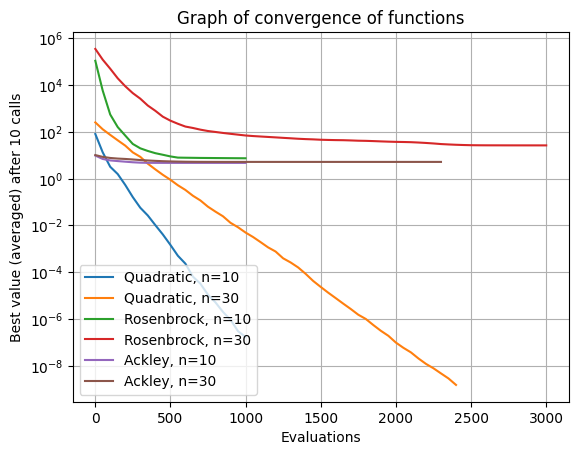

In [16]:
if __name__ == "__main__":
    for func, name in [(quadratic, "Quadratic"), (rosenbrock, "Rosenbrock"), (ackley, "Ackley")]: #iteracja po funkcjach
        for n in [10, 30]: #iteracja po wymiarach
            all_histories = []

            #10 wywołań solwera
            for _ in range(10):
                x0 = np.random.uniform(-5, 5, n)
                params = SolverParameters(n=n, max_evals=n*100, sigma0=0.5, bounds=(-5, 5))
                result = solver(func, x0, params)
                evals, best_values = zip(*result.history) #rozdział listy na 2 sekwencje
                all_histories.append(best_values)

            min_len = min(len(h) for h in all_histories)
            all_histories = np.array([h[:min_len] for h in all_histories]) #rozmiar (10, min_len)
            evals = np.array([e for e, _ in result.history])[:min_len]

            #średnia po 10 wywołaniach
            mean_best_values = np.mean(all_histories, axis=0)
            #rysowanie wykresu
            plt.plot(evals, mean_best_values, label=f"{name}, n={n}")

    #konfiguracja opcji wykresu
    plt.yscale("log")
    plt.xlabel("Evaluations")
    plt.ylabel("Best value (averaged) after 10 calls")
    plt.title("Graph of convergence of functions")
    plt.grid(True)
    plt.legend()
    plt.show()

#### Dla n=10 i n=30 osobne wykresy i dla każdej funkcji osobny, porównać pojedyncze funkcje dla różnych wartości sigma np. 0,001 0,01 